In [28]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('tree_methods_adv').getOrCreate()
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
import matplotlib.pyplot as plt


In [4]:
data = spark.read.csv("Data/finalmergedlog10.csv",inferSchema=True,header=True)
data.show()

+----+-------------------+--------------------+---------------------+--------------------------+-----------------------------+---------------+----------------+-------------+--------------+-----------+------------+----------+-----------+----------------------------------+-----------------------------------------------------+
|Year|United States Total|United States 1 Unit|United States 2 Units|United States 3 to 4 units|United States 5 Units or More|Northeast Total|Northeast 1 Unit|Midwest Total|Midwest 1 Unit|South Total|South 1 Unit|West Total|West 1 Unit|HONEY - PRODUCTION, MEASURED IN LB|HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES|
+----+-------------------+--------------------+---------------------+--------------------------+-----------------------------+---------------+----------------+-------------+--------------+-----------+------------+----------+-----------+----------------------------------+-----------------------------------------------------+
|1990|             111

In [5]:
data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- United States Total: double (nullable = true)
 |-- United States 1 Unit: double (nullable = true)
 |-- United States 2 Units: double (nullable = true)
 |-- United States 3 to 4 units: double (nullable = true)
 |-- United States 5 Units or More: double (nullable = true)
 |-- Northeast Total: double (nullable = true)
 |-- Northeast 1 Unit: double (nullable = true)
 |-- Midwest Total: double (nullable = true)
 |-- Midwest 1 Unit: double (nullable = true)
 |-- South Total: double (nullable = true)
 |-- South 1 Unit: double (nullable = true)
 |-- West Total: double (nullable = true)
 |-- West 1 Unit: double (nullable = true)
 |-- HONEY - PRODUCTION, MEASURED IN LB: double (nullable = true)
 |-- HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES: double (nullable = true)



In [128]:
#assembler = VectorAssembler(
 #   inputCols=["United States Total", "United States 1 Unit","United States 2 Units", "United States 3 to 4 units",
  #            "United States 5 Units or More", "Northeast Total", "Northeast 1 Unit", "Midwest Total", "Midwest 1 Unit",
   #           "South Total", "South 1 Unit", "West Total", "West 1 Unit"],
    #outputCol="features")

In [6]:
feature_list = []
for col in data.columns:
    if col == 'HONEY - PRODUCTION, MEASURED IN LB':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [156]:
#output = assembler.transform(data)

In [130]:
#output.printSchema()


root
 |-- Year: integer (nullable = true)
 |-- United States Total: double (nullable = true)
 |-- United States 1 Unit: double (nullable = true)
 |-- United States 2 Units: double (nullable = true)
 |-- United States 3 to 4 units: double (nullable = true)
 |-- United States 5 Units or More: double (nullable = true)
 |-- Northeast Total: double (nullable = true)
 |-- Northeast 1 Unit: double (nullable = true)
 |-- Midwest Total: double (nullable = true)
 |-- Midwest 1 Unit: double (nullable = true)
 |-- South Total: double (nullable = true)
 |-- South 1 Unit: double (nullable = true)
 |-- West Total: double (nullable = true)
 |-- West 1 Unit: double (nullable = true)
 |-- HONEY - PRODUCTION, MEASURED IN LB: double (nullable = true)
 |-- HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES: double (nullable = true)
 |-- features: vector (nullable = true)



In [160]:
#final_data = output.select("features","HONEY - PRODUCTION, MEASURED IN LB")
#final_data.show()

+--------------------+----------------------------------+
|            features|HONEY - PRODUCTION, MEASURED IN LB|
+--------------------+----------------------------------+
|[1990.0,1110.8,79...|                 8.298003298071777|
|[1991.0,948.8,753...|                 8.344441399241624|
|[1992.0,1094.9,91...|                 8.345683410316864|
|[1993.0,1199.1,98...|                 8.362979818962618|
|[1994.0,1371.6,10...|                 8.338570032823604|
|[1995.0,1332.5,99...|                 8.324621936747661|
|[1996.0,1425.6,10...|                  8.30009308116713|
|[1997.0,1441.1,10...|                 8.293223292933632|
|[1998.0,1612.3,11...|                 8.343461769464422|
|[1999.0,1663.5,12...|                 8.307641491507416|
|[2000.0,1592.3,11...|                 8.342986896987583|
|[2001.0,1636.7,12...|                 8.269632008640352|
|[2002.0,1747.7,13...|                 8.234815821607878|
|[2003.0,1889.2,14...|                 8.259412287678185|
|[2004.0,2070.

In [7]:
rf = RandomForestRegressor(labelCol="HONEY - PRODUCTION, MEASURED IN LB", featuresCol="features")

In [8]:
pipeline = Pipeline(stages=[assembler, rf])

In [9]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [17]:
#crossval = CrossValidator(estimator=pipeline,
 #                         estimatorParamMaps=paramGrid,
  #                        evaluator=RegressionEvaluator(),
   #                       numFolds=2)

In [10]:
#train_data,test_data = final_data.randomSplit([0.7,0.3])
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [ ]:
#trainingData.describe().show()

#testData.describe().show()

In [22]:
#cvModel = crossval.fit(trainingData)

In [11]:
model = pipeline.fit(trainingData)

In [12]:
predictions = model.transform(testData)

In [13]:
predictions.select("prediction", "HONEY - PRODUCTION, MEASURED IN LB", "features").show(10)

+-----------------+----------------------------------+--------------------+
|       prediction|HONEY - PRODUCTION, MEASURED IN LB|            features|
+-----------------+----------------------------------+--------------------+
| 8.30490845736727|                 8.298003298071777|[1990.0,1110.8,79...|
|8.304852084164995|                 8.344441399241624|[1991.0,948.8,753...|
|8.313961102218503|                 8.338570032823604|[1994.0,1371.6,10...|
|8.283202854286886|                  8.30009308116713|[1996.0,1425.6,10...|
|8.283202854286886|                 8.293223292933632|[1997.0,1441.1,10...|
|8.285103328430239|                 8.343461769464422|[1998.0,1612.3,11...|
|8.263490887924917|                 8.342986896987583|[2000.0,1592.3,11...|
|8.235235046732054|                 8.259412287678185|[2003.0,1889.2,14...|
|8.231593763237075|                 8.263621867991414|[2004.0,2070.1,16...|
|8.221483488643555|                 8.242079061127843|[2005.0,2155.3,16...|
+-----------

In [14]:
evaluator = RegressionEvaluator(
    labelCol="HONEY - PRODUCTION, MEASURED IN LB", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0376072


In [15]:
rfModel = model.stages[1]
print(rfModel)

RandomForestRegressionModel (uid=rfr_623f9e453b81) with 20 trees


In [30]:


evaluator = RegressionEvaluator(labelCol="HONEY - PRODUCTION, MEASURED IN LB", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

rfPred = model.transform(data)
rfResult = rfPred.toPandas()

print(rfResult)

    Year  United States Total  United States 1 Unit  United States 2 Units  \
0   1990               1110.8                 793.9                   26.7   
1   1991                948.8                 753.5                   22.0   
2   1992               1094.9                 910.7                   23.3   
3   1993               1199.1                 986.5                   26.7   
4   1994               1371.6                1068.5                   31.4   
5   1995               1332.5                 997.3                   32.2   
6   1996               1425.6                1069.5                   33.6   
7   1997               1441.1                1062.4                   34.9   
8   1998               1612.3                1187.6                   33.2   
9   1999               1663.5                1246.7                   32.5   
10  2000               1592.3                1198.1                   30.6   
11  2001               1636.7                1235.6             

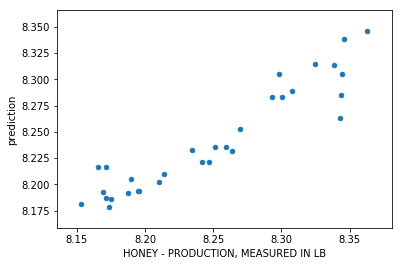

In [32]:
import matplotlib.pyplot as plt

rfResult.plot.scatter(x='HONEY - PRODUCTION, MEASURED IN LB', y='prediction', style='o')